In [18]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

## Locations


In [19]:
tower_roof = things.Location(
    "Tower Roof",
    "You are inside a Tower Roof."
)

hallway = things.Location(
    "Hallway",
    "You are walking along the hallway."
)

armory = things.Location(
    "Armory",
    "You are at the armory. You can see a collections of swords"
)

basement = things.Location(
    "Basement",
    "You are at the Basement of the house. There is a Skeleton here."
)

treasure_lock= things.Location(
    "Treasure lock",
    "You are standing in front of a locked treasure box."
)

treasure = things.Location(
    "Treasure",
    "A treasure with a necklace"
)

basement_stairs = things.Location(
    "Basement Stairs",
    "You are climbing the stairs down to the basement."
)

death = things.Location(
    "The Afterlife",
    "The Skeleton kills you. You are dead. GAME OVER."
)
death.set_property("game_over", True)

# Map of Locations
tower_roof.add_connection("down", hallway)
hallway.add_connection("south", armory)
hallway.add_connection("down", basement_stairs)
basement_stairs.add_connection("down", basement)
hallway.add_connection("east", treasure_lock)
armory.add_connection("north", hallway)
basement.add_connection("run", death)
treasure_lock.add_connection("east", treasure)


###  Preliminary Game Map


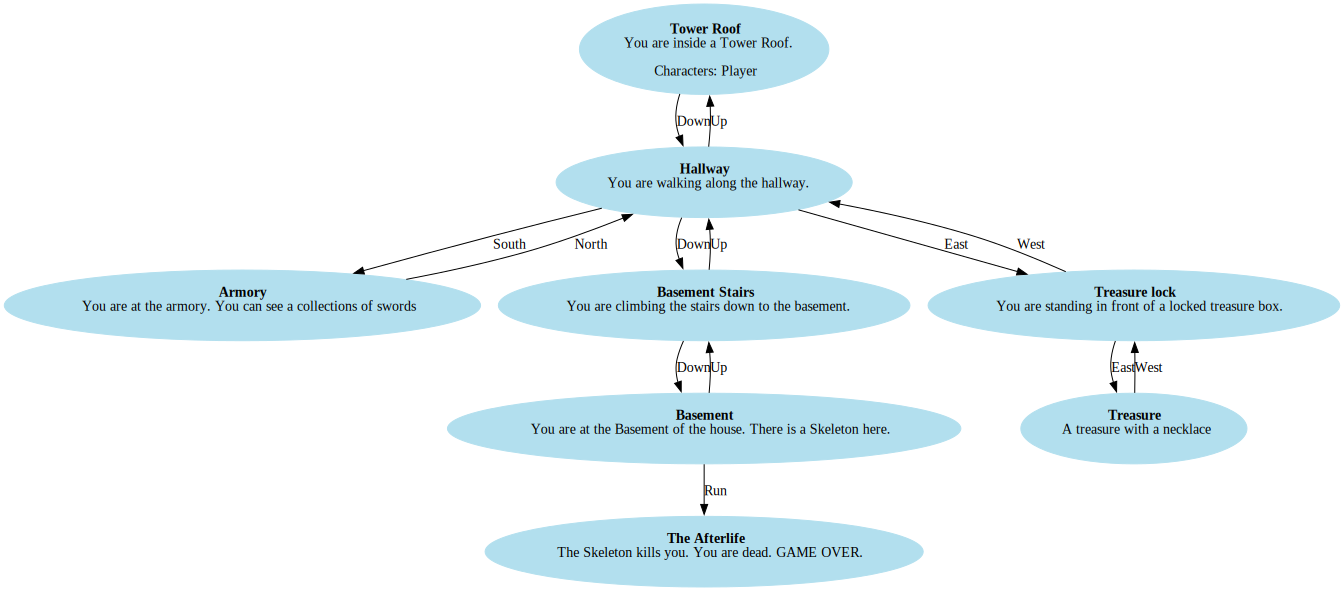

In [20]:
tempgame = games.Game(tower_roof, things.Character(name="Player", description="", persona=""))

from text_adventure_games.viz import Visualizer
viz = Visualizer(tempgame)
graph = viz.visualize()
graph

## Items

### Gettable Items

In [21]:
torch = things.Item(
    "torch",
    "a torch that lights",
    "a simple torch which lights up dark space",
)
torch.set_property("is_lightable", True)
torch.set_property("is_lit", False)
torch.add_command_hint("light the torch")
hallway.add_item(torch)

note = things.Item(
    "note",
    "a note to read",
    "the note conatins a hint to solve the puzzle"
)
note.set_property("is_readable", True)
note.set_property("is_read", False)
note.add_command_hint("read the note to get a hint")
hallway.add_item(note)

sword = things.Item(
    "sword",
    "a sword used to defend",
    "a sword that is helpful to progress in the game"
)
sword.set_property("is_weapon", True)
armory.add_item(sword)



### Scenery Items

_We called these "non-gettable" in the tutorial_

In [22]:
treasure_box = things.Item(
    "treasure box",
    "a treasure box",
    "THE TREASURE BOX HAS A BEAUTIFUL PIECE OF NECKLACE.",
)
treasure_box.set_property("gettable", False)
treasure_box.set_property("has_necklace", True)
treasure_box.add_command_hint("steal necklace")
treasure.add_item(treasure_box)


door = things.Item(
    "treasure door",
    "a treasure door",
    "THE TREASURE IS SECURELY LOCKED."
)
door.set_property("gettable", False)
door.set_property("is_locked", True)
door.add_command_hint("unlock treasure")
treasure_lock.add_item(door)


## Characters

### Player

In [23]:
# Player
player = things.Character(
    name="The player",
    description="You are a simple peasant destined for greatness.",
    persona="I am on an adventure.",
)

### Non-Player Characters (NPCs)

In [24]:
skeleton = things.Character(
    name="skeleton",
    description="A key guard",
    persona="I will prevent people from entering and stealing the necklace.",
)
skeleton.set_property("character_type", "skeleton")
skeleton.set_property("is_banished", False)
basement.add_character(skeleton)

key = things.Item("key", "a brass key", "THIS LOOKS USEFUL")
skeleton.add_to_inventory(key)

## Actions

In [25]:
class Unlock_Treasure(actions.Action):
    ACTION_NAME = "unlock treasure"
    ACTION_DESCRIPTION = "Unlock a treasure with a key"
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        
        self.character = self.parser.get_character(command)
        self.key = self.parser.match_item(
            "key", self.parser.get_items_in_scope(self.character)
        )
        self.door = self.parser.match_item(
            "treasure door", self.parser.get_items_in_scope(self.character)
        )
        self.location = self.character.location
       

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * There must be a door
        * The character must be at the same location as the door
        * The door must be locked
        * The character must have the key in their inventory
        """
       
        if not self.door:
            message = "There is no door."
            self.parser.fail(message)
            return False
        
        if not self.location.here(self.character):
            message = "{name} is not at {location_name}".format(
            name=self.character.name.capitalize(),
            location_name=self.location.name.capitalize()
            )
            self.parser.fail(message)
            return False
        
        if not self.door.get_property("is_locked"):
            message = "The door is already unlocked."
            self.parser.fail(message)
            return False

        if not self.character.is_in_inventory(self.key):
            message = "The character does not have the key to unlock the door."
            self.parser.fail(message)
            return False

        return True

        

    def apply_effects(self):
        """
        Effects:
        * Unlocks the door
        """
        self.door.set_property("is_locked", False)
        self.parser.ok("Treasure is unlocked")

In [26]:
class Read_Note(actions.Action):
    ACTION_NAME = "read note"
    ACTION_DESCRIPTION = "A note with a hint"
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        self.character: things.Character = self.parser.get_character(command)
        self.note: things.Item = self.parser.match_item(
            "note", self.parser.get_items_in_scope(self.character)
        )
        self.location = self.character.location

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * The character must be in same location
          Necklace must be there
        """
        if not self.location.here(self.character):
            message = "{name} is not at {location_name}".format(
            name=self.character.name.capitalize(),
            location_name=self.location.name.capitalize()
            )
            self.parser.fail(message)
            return False
        
        if self.note.get_property("is_read"):
            message = "The hint has already been read."
            self.parser.fail(message)
            return False
        
        
        return True
    
    def apply_effects(self):
            """
            The hint has to be printed.
            """
            description = "The key lies where the bones rest."
            self.parser.ok(description)

            self.character.set_property("is_read", True)

In [27]:
class Steal_necklace(actions.Action):
    ACTION_NAME = "steal necklace"
    ACTION_DESCRIPTION = "Steal the necklace from the treasure"
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        self.character: things.Character = self.parser.get_character(command)
        self.treasure_box: things.Item = self.parser.match_item(
            "treasure box", self.parser.get_items_in_scope(self.character)
        )
        self.location = self.character.location

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * The character must be in same location as the treasure box
          Necklace must be there
        """
        if not self.location.here(self.character):
            message = "{name} is not at {location_name}".format(
            name=self.character.name.capitalize(),
            location_name=self.location.name.capitalize()
            )
            self.parser.fail(message)
            return False
        
        if not self.treasure_box.get_property("has_necklace"):
            message = "The necklace has already been stolen."
            self.parser.fail(message)
            return False
        
        
        return True
    
    def apply_effects(self):
            """
            The character has stolen the necklace.
            """
            description = "Hurray! {character} has sucessfully stolen the necklace.".format(
                character=self.character.name,
            )
            self.parser.ok(description)

            self.character.set_property("has_stolen", True)
        
        


In [28]:
class Attack_Skeleton(actions.Action):
    ACTION_NAME = "attack skeleton with sword"
    ACTION_DESCRIPTION = "Attack the skeleton"
    ACTION_ALIASES = []

    def __init__(self, game, command):
        super().__init__(game)
        self.character: things.Character = self.parser.get_character(command)
        self.sword: things.Item = self.parser.match_item(
            "sword", self.parser.get_items_in_scope(self.character)
        )
        self.skeleton: things.Character = self.parser.get_character("skeleton")
        self.location = self.skeleton.location
        

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * The character must have the sword in their inventory
        * the skeleton must be in this location
        """
        if not self.sword:
            message = "There is no sword."
            self.parser.fail(message)
            return False
        if not self.character.is_in_inventory(self.sword):
            message = "The character does not have the sword."
            self.parser.fail(message)
            return False
        if not self.location.here(self.skeleton):
            message = "{name} is not at {location_name}".format(
            name=self.skeleton.name.capitalize(),
            location_name=self.location.name.capitalize()
            )
            self.parser.fail(message)
            return False
        
        
        return True
    
    def apply_effects(self):
        """
        Effects:
        * Banishes the skeleton, causing it to drop its inventory.
        """
        self.skeleton.set_property("is_banished", True)
        description = "The {skeleton} is banished.".format(
            skeleton=self.skeleton.name,
        )
        self.parser.ok(description)

        items = list(self.skeleton.inventory.keys())
        for item_name in items:
            item = self.skeleton.inventory[item_name]
            command = "{skeleton} drop {item}".format(
                skeleton=self.skeleton.name, item=item_name
            )
            drop = actions.Drop(self.game, command)
            if drop.check_preconditions():
                drop.apply_effects()
    

## Blocks

In [29]:
class Darkness(blocks.Block):
    
    def __init__(self, location: things.Location, torch:things.Item):
        super().__init__("Darkness blocks your way", "It's too dark to go that way.")
        self.location = location
        self.torch=torch
        
        

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * The location is dark
        # * Unblocked if any character at the location is carrying a lit item 
        #   (like a lamp or candle)
        self.location.set_property("is_dark", True)

        if self.torch.get_property("is_lit"):
            return False

        
        return True

In [30]:
class Treasure_Block(blocks.Block):
    def __init__(self, location: things.Location, door: things.Item):
        super().__init__("A locked treasure blocks your way", "The treasure ahead is locked.")
        # TODO - your code here
        self.location = location
        self.door = door

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * The door is locked
        if self.door.get_property("is_locked"):
            return True
        
        
        return False

In [31]:
basement_block = Darkness(basement_stairs, torch)
basement_stairs.add_block("down", basement_block)

treasure_block = Treasure_Block(treasure_lock, door)
treasure_lock.add_block("east", treasure_block)

## Play Game

In [32]:
class PlayGame(games.Game):
    def __init__(
        self, start_at: things.Location, player: things.Character, characters=None,
        custom_actions=None
    ):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)

    def is_won(self) -> bool:
        """ 
        Checks whether the game has been won.  The game is won
        once any character has stolen the necklace (has the property has_stolen).
        """
        for name, character in self.characters.items():
            if character.get_property("has_stolen"):
                msg = "{name} has the necklace! {name} has won the game!"
                self.parser.ok(msg.format(name=character.name.title()))
                return True
        return False

In [33]:
characters = [skeleton]
custom_actions = [Unlock_Treasure, Read_Note, Steal_necklace, Attack_Skeleton]

# The Game
game = PlayGame(tower_roof, player, characters=characters, custom_actions=custom_actions)

In [34]:
game.game_loop()

You are inside a Tower Roof.
Exits:
Down to Hallway


Characters:
 *

You are walking along the hallway.
Exits:
Up to Tower Roof
South to Armory
Down to Basement Stairs
East to Treasure lock

You see:
 * a torch that lights
        light the torch
 * a note to read
        read the note to get a hint


The player got the torch.
The key lies where the bones rest.
You are at the armory. You can see a collections of swords
Exits:
North to Hallway

You see:
 * a sword used to defend


The player got the sword.
I'm not sure what you want to do.
You are walking along the hallway.
Exits:
Up to Tower Roof
South to Armory
Down to Basement Stairs
East to Treasure lock

You see:
 * a note to read
        read the note to get a hint


You are climbing the stairs down to the basement.
Exits:
Up to Hallway
Down to Basement




It's too dark to go that way.
The player lights the torch. It glows.
You are at the Basement of the house. There is a Skeleton here.
Exits:
Up to Basement Stairs
Run to The Af